In [2]:
import os
import librosa
import torch
import random
import keras
import soundfile as sf
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

In [3]:
# if gpu is available, use it
if tf.config.list_physical_devices('GPU'):
    device = 'gpu'
else:
    device = 'cpu'
    
# if gpu is available, use it
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
OUTPUT_DIR: str = "output/"
CSV_FILE_PATH: str = "bio_metadata.csv"
NATIVE_FILE_PATH: str = "native_bio_metadata.csv"
NON_NATIVE_FILE_PATH: str = "non_native_bio_metadata.csv"
NATIVE_LANGUAGES: list[str] = ['uk', 'usa', 'canada']
NON_NATIVE_LANGUAGES: list[str] = [
    'australia',
    'new zealand',
    'ireland',    
    'singapore',  
    'south',     
    'africa',   
    'jamaica',    
    'scotland',   
    'islands',
]
DATASET_DIR: str = "data/"
NATIVE_DIR: str = "data/native/"
NATIVE_COMBINED_DIR: str = "data/native_combined/"
NON_NATIVE_DIR: str = "data/non_native/"
AUDIO_DATA_DIR: str = "data/audio/"
AUDIO_FILE_PATH: str = "data/audio/{}.wav"
SILENCE_THRESHOLD: float = .01
RATE: int = 2400
N_MFCC: int = 13
COL_SIZE: int = 30
EPOCHS: int = 100 #35 #50 #250
LEARNING_RATE = 0.001
WAIT: float = 1.2
DEBUG: bool = True


In [5]:
class XFeatureExtractor:
    """
        Extracts acoustic and prosodic features from audio files.
    """
    
    @staticmethod
    def extract_acoustic_features(file_path, features=('mfcc', 'chroma_stft', 'spectral_centroid')):
        try:
            y, sr = librosa.load(f'data/audio/{file_path}.wav')
            features_dict = {}
            for feature_name in features:
                if feature_name == 'mfcc':
                    features_dict['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                elif feature_name == 'chroma_stft':
                    features_dict['chroma_stft'] = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
                elif feature_name == 'spectral_centroid':
                    features_dict['spectral_centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr)
                elif feature_name == 'spectral_bandwidth':
                    features_dict['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                elif feature_name == 'zero_crossing_rate':
                    features_dict['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(
                        y=y, 
                        frame_length=2048,
                        hop_length=512
                    )
                elif feature_name == 'rmse':
                    features_dict['rmse'] = librosa.feature.rms(y=y)
                else:
                    raise ValueError(f"Unsupported feature: {feature_name}")

            return features_dict
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return None  # Or handle error differently

    @staticmethod
    def extract_prosodic_features(file_path, features=('pitch', 'intensity', 'duration')):
        try:
            y, sr = librosa.load(f'data/audio/{file_path}.wav')
            prosodic_features = {}
            for feature_name in features:
                if feature_name == 'pitch':
                    prosodic_features['pitch'] = librosa.yin(y=y, fmin=65, fmax=2093)
                elif feature_name == 'intensity':
                    prosodic_features['intensity'] = librosa.feature.rms(y=y)
                elif feature_name == 'duration':
                    prosodic_features['duration'] = len(y) / sr
                elif feature_name == 'formants':
                    # Implement formant extraction using librosa or a custom solution
                    prosodic_features['formants'] = None  # Placeholder for now
                else:
                    raise ValueError(f"Unsupported feature: {feature_name}")
            return prosodic_features
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return None  # Handle loading errors

    @staticmethod
    def extract_plp(file_path):
        y, sr = librosa.load(f'data/audio/{file_path}.wav')
        plp = librosa.beat.plp(y=y, sr=sr)
        return plp


In [6]:
class FeatureExtractorUtils:
    """
        Extracts acoustic features from audio files and preprocesses them for language identification.
    """

    def __init__(self):
        pass  # No initialization needed for now
    
    @staticmethod
    def to_categorical(y):
        '''
            Converts list of languages into a binary class matrix
            :param y (list): list of languages
            :return (numpy array): binary class matrix
        '''
        lang_dict = {}
        for index, language in enumerate(set(y)):
            lang_dict[language] = index
        y = list(map(lambda x: lang_dict[x],y))
        return keras.utils.to_categorical(y, len(lang_dict)), lang_dict

    @staticmethod
    def get_wav(filename):
        """
            Loads a wav file from disk and resamples to a target sample rate.

            Args:
                filename (str): Path to the wav file.

            Returns:
                numpy.ndarray: Down-sampled wav file (or None if an error occurs).
        """
        try:
            y, sr = librosa.load(f'./data/native_combined/{filename}.wav')
            return librosa.core.resample(y=y, orig_sr=sr, target_sr=RATE, scale=True)
        except Exception as e:
            print(f"Error loading wav: {filename} - {e}")
            return None  # Or handle error differently

    @staticmethod
    def to_mfcc(wav):
        """
            Converts a wav file to Mel Frequency Ceptral Coefficients (MFCCs).
            Args:
                wav (numpy array): The wav form data.
                sr (int, optional): The sample rate of the audio. Defaults to None (use from data if available).
                n_mfcc (int, optional): The number of MFCC coefficients to extract. Defaults to None (use librosa's default).
            Returns:
                numpy.ndarray: A 2D numpy array containing the MFCC features.
            Raises:
                Exception: If an error occurs during processing.
        """
        try:
            return librosa.feature.mfcc(y=wav, sr=RATE, n_mfcc=N_MFCC)
        except Exception as e:
            print(f"Error converting wav to MFCC: {e}")
            return None  # Or handle error differently

    @staticmethod
    def normalize_mfcc(mfcc):
        '''
            Normalize mfcc
            :param mfcc:
            :return:
        '''
        mms = MinMaxScaler()
        return(mms.fit_transform(np.abs(mfcc)))

    @staticmethod
    def remove_silence(wav, thresh=0.04, chunk=5000):
        '''
            Searches wav form for segments of silence. If wav form values are lower than 'thresh' for 'chunk' samples, the values will be removed
            :param wav (np array): Wav array to be filtered
            :return (np array): Wav array with silence removed
        '''

        tf_list = []
        for x in range(len(wav) / chunk):
            if (np.any(wav[chunk * x:chunk * (x + 1)] >= thresh) or np.any(wav[chunk * x:chunk * (x + 1)] <= -thresh)):
                tf_list.extend([True] * chunk)
            else:
                tf_list.extend([False] * chunk)

        tf_list.extend((len(wav) - len(tf_list)) * [False])
        return(wav[tf_list])

    @staticmethod
    def make_segments(mfccs,labels):
        '''
            Makes segments of mfccs and attaches them to the labels
            :param mfccs: list of mfccs
            :param labels: list of labels
            :return (tuple): Segments with labels
        '''
        segments = []
        seg_labels = []
        for mfcc,label in zip(mfccs,labels):
            for start in range(0, int(mfcc.shape[1] / COL_SIZE)):
                segments.append(mfcc[:, start * COL_SIZE:(start + 1) * COL_SIZE])
                seg_labels.append(label)
        return (segments, seg_labels)

    @staticmethod
    def segment_one(mfcc):
        '''
            Creates segments from on mfcc image. If last segments is not long enough to be length of columns divided by COL_SIZE
            :param mfcc (numpy array): MFCC array
            :return (numpy array): Segmented MFCC array
        '''
        segments = []
        for start in range(0, int(mfcc.shape[1] / COL_SIZE)):
            segments.append(mfcc[:, start * COL_SIZE:(start + 1) * COL_SIZE])
        return(np.array(segments))

    @staticmethod
    def create_segmented_mfccs(X_train):
        '''
            Creates segmented MFCCs from X_train
            :param X_train: list of MFCCs
            :return: segmented mfccs
        '''
        segmented_mfccs = []
        for mfcc in X_train:
            segmented_mfccs.append(FeatureExtractorUtils.segment_one(mfcc))
        return(segmented_mfccs)

    @staticmethod
    def extract_mfcc_lst(audio_segment, sr=22050, n_mfcc=13, mel_filter_bank=20):
        """
            Extracts MFCCs from a given audio segment.
            Args:
                :param audio_segment: A NumPy array of the audio data.
                :param sr: Sampling rate of the audio (default: 22050 Hz).
                :param n_mfcc: Number of MFCC coefficients to extract (default: 13).
                :param mel_filter_bank: Number of mel filters to use (default: 20).
            Returns:
                A NumPy array of MFCC features for the audio segment.
        """
        mel_spectrogram = librosa.feature.melspectrogram(
            audio_segment, sr=sr, n_mels=mel_filter_bank
        )
        mfcc_lst = librosa.feature.mfcc(
            S=librosa.power_to_db(mel_spectrogram), 
            n_mfccs=n_mfcc
        )
        return mfcc_lst.T  # Transpose to have features as columns

    @staticmethod
    def normalize_mfcc_lst(mfcc_lst: np.array, method: str = None) -> np.array:
        """
            Normalizes MFCC features.

            Args:
                :param mfcc_lst: A NumPy array of MFCC features.
                :param method: Normalization method (default: None) -> This will use the MinMaxScaler.
                        Supported methods: 'minmax', 'standard'

            Returns:
                :return: The normalized MFCC features.
        """
        if method == 'minmax':
            return (mfcc_lst - np.min(mfcc_lst)) / (np.max(mfcc_lst) - np.min(mfcc_lst))
        elif method == 'standard':
            return (mfcc_lst - np.mean(mfcc_lst)) / np.std(mfcc_lst)
        else:
            mms = MinMaxScaler()
            return mms.fit_transform(np.abs(mfcc_lst))

    @staticmethod
    def reduce_dimensionality(mfcc_lst: np.array, n_components: int = 10) -> np.array:
        """
            Reduces the dimensionality of MFCC features using PCA.
            The number of principal components to retain is specified by n_components.

            Args:
                :param mfcc_lst: A NumPy array of MFCC features.
                :param n_components: Number of principal components to retain (default: 10).

            Returns:
                :return: The reduced MFCC features.
        """
        pca = PCA(n_components=n_components)
        reduced_mfcc_lst = pca.fit_transform(mfcc_lst)
        return reduced_mfcc_lst

    @staticmethod
    def combine_segments(mfcc_segments: list, method='mean'):
        """
            Combines MFCC features from multiple segments.
            Args:
                :param mfcc_segments: A list of NumPy arrays of MFCC features, one for each segment.
                :param method: Method for combining features (default: 'mean').
                        Supported methods: 'mean', 'concatenate'
            Returns:
                :return: A NumPy array of combined MFCC features.
        """
        if method == 'mean':
            return np.mean(mfcc_segments, axis=0)
        elif method == 'concatenate':
            return np.concatenate(mfcc_segments, axis=1)
        else:
            raise ValueError(f"Invalid combination method: {method}")

    @staticmethod
    def filter_df(dataframe: pd.DataFrame) -> pd.DataFrame:
        """
            Function to filter audio files based on df columns
            df column options: [age,age_of_english_onset,age_sex,birth_place,english_learning_method,
            english_residence,length_of_english_residence,native_language,other_languages,sex]
            :return (DataFrame): Filtered DataFrame
        """

        # if the dataframe['native_language'] has arabic, mandarin, or english then
        arabic = dataframe[dataframe.native_language == 'arabic']
        mandarin = dataframe[dataframe.native_language == 'mandarin']
        english = dataframe[dataframe.native_language == 'english']
        mandarin = mandarin[mandarin.length_of_english_residence < 10]
        arabic = arabic[arabic.length_of_english_residence < 10]
        # use concat to add the dataframes together
        return pd.concat(
            [
                dataframe,
                mandarin,
                arabic,
                english,
            ],
            ignore_index=True
        )

    @staticmethod
    def split_people(dataframe: pd.DataFrame, test_size: float = 0.2, second_column: str = 'english_residence'):
        """
            Create train test split of DataFrame
            Args:
                :param dataframe: DataFrame to be split
                :param test_size: Percentage of total files to be split into test
            Return:
                :return X_train, X_test, y_train, y_test (tuple): Xs are list of
                df['language_num'] and Ys are df['english_residence']
        """
        x_train, x_test, y_train, y_test = train_test_split(
            dataframe['language_num'],
            dataframe[second_column],
            test_size=test_size,
            train_size= 1 - test_size,
            random_state=1234
        )
        return x_train, x_test, y_train, y_test


In [7]:
class AudioFeatureExtractor:
    def __init__(self, path:str) -> None:
        """
            Initializes the feature extractor with the directory containing audio files of native speakers.
            Args:
                path (str): Directory path containing audio files of the native English speakers.
        """
        self.native_speakers_dir = path
        self.native_speakers_data = self.load_native_speakers_files()

    def load_native_speakers_files(self):
        """
            Loads the file paths of all audio files in the native speakers directory.
            Returns:
                list: A list containing the file paths of the native English speakers' audio files.
        """
        # This will list every file in the directory
        file_paths = [file for file in os.listdir(self.native_speakers_dir) if file.endswith('.wav')]
        return file_paths

    
    def combine_native_speakers(self, file_path, num_samples=1):
        """
            Combines a 1-second voice sample from the specified file with another 1-second sample
            from a randomly selected native speaker's voice to create a 2-second sample.
            Args:
                file_path (str): Path to the primary audio file.
                num_samples (int): Number of 1-second samples to combine with, should be 1 for a 2-second sample.
            Returns:
                np.ndarray: The combined 2-second audio waveform.
        """
        # print(os.path.join(self.native_speakers_dir, file_path))
        try:
            # Load the primary audio file and take a 1-second sample
            primary_y, sr = librosa.load(os.path.join(self.native_speakers_dir, file_path), sr=None)
            # primary_one_second = librosa.util.fix_length(primary_y, sr)[:sr]
            primary_one_second = librosa.util.fix_length(primary_y, size=num_samples)

            # Randomly select another native speaker file and take a 1-second sample
            random_file_path = random.choice(self.native_speakers_data)
            random_y, _ = librosa.load(os.path.join(self.native_speakers_dir, random_file_path), sr=None)
            # random_one_second = librosa.util.fix_length(random_y, sr)[:sr]
            random_one_second = librosa.util.fix_length(random_y, size=num_samples)

            # Concatenate the two 1-second samples to create a 2-second sample
            combined_y = np.concatenate((primary_one_second, random_one_second))
            return combined_y, sr

        except Exception as e:
            print(f"Error combining native speaker samples for {file_path}: {e}")
            return None, None


In [8]:
# # audio feature extraction instance
# audio_feature_extractor = AudioFeatureExtractor(path=NATIVE_DIR)
# # load native speaker files
# native_speakers_data = audio_feature_extractor.load_native_speakers_files()

In [9]:
# # # # NB: Only run this cell once to combine all native speakers

# # load all native speakers
# # native_speakers = []
# # native_sr = []
# os.makedirs('./data/native_combined', exist_ok=True)
# for file in native_speakers_data:
#     combined_y, sr = audio_feature_extractor.combine_native_speakers(file_path = file, num_samples = 1)
#     # native_speakers.append(combined_y)
#     # native_sr.append(sr)
#     sf.write(f'./data/native_combined/{file}', combined_y, sr, subtype='PCM_24')
#     # librosa.output.write_wav(f'data/audio/combined/{file}', combined_y, sr)

In [10]:
# load the native_bio_metadata.csv
native_bio_metadata = pd.read_csv(NATIVE_FILE_PATH)
native_bio_metadata.head()

,href,language_num,sex,birth_place,native_language,other_languages,age_sex,age_of_english_onset,english_learning_method,english_residence,length_of_english_residence,age
0,http://accent.gmu.edu/browse_language.php?func...,mandarin1,female,"['shanxi,', 'china']",mandarin\n(cmn),['none'],"['26,', 'female', '']",13.0,academic,usa,2.0,26.0
1,http://accent.gmu.edu/browse_language.php?func...,mandarin2,female,"['nanjing,', 'china']",mandarin\n(cmn),"['japanese', '']","['38,', 'female', '']",14.0,academic,usa,0.8,38.0
2,http://accent.gmu.edu/browse_language.php?func...,mandarin3,male,"['jilin,', 'china']",mandarin\n(cmn),"['italian', 'german', 'french', '']","['43,', 'male', '']",10.0,academic,usa,14.0,43.0
3,http://accent.gmu.edu/browse_language.php?func...,mandarin4,female,"['shanghai,', 'china']",mandarin\n(cmn),"['japanese', '']","['24,', 'female', '']",6.0,academic,usa,1.0,24.0
4,http://accent.gmu.edu/browse_language.php?func...,mandarin5,female,"['beijing,', 'china']",mandarin\n(cmn),['none'],"['31,', 'female', '']",12.0,academic,usa,2.0,31.0


In [11]:
featureExtractorUtils = FeatureExtractorUtils()
xFeatureExtractor = XFeatureExtractor()

In [12]:
# split the native_combined_df into train and test
X_train, X_test, y_train, y_test = featureExtractorUtils.split_people(native_bio_metadata, test_size=0.1)

In [13]:
print(X_test.shape, y_test.shape)

(245,) (245,)


In [14]:
print(X_train.shape, y_train.shape)

(979,) (979,)


In [15]:
y_test = y_test.apply(lambda x: x.split('\n')[0])
y_train = y_train.apply(lambda x: x.split('\n')[0])

In [16]:
# Get statistics
train_count = Counter(y_train)
test_count = Counter(y_test)


print(f"Train Count: {train_count}")
print(f"Test Count: {test_count}")

Train Count: Counter({'usa': 824, 'uk': 95, 'canada': 60})
Test Count: Counter({'usa': 207, 'uk': 20, 'canada': 18})


In [17]:
# y_train_encoded = LabelEncoder().fit_transform(y_train)
# y_test_encoded = LabelEncoder().fit_transform(y_test)
# y_train_cat = to_categorical(y_train_encoded)
# y_test_cat = to_categorical(y_test_encoded)

y_train_cat, _ = featureExtractorUtils.to_categorical(y_train)
y_test_cat, lang_dict = featureExtractorUtils.to_categorical(y_test)

In [18]:
lang_dict

{'canada': 0, 'uk': 1, 'usa': 2}

# Extract Prosodic, Accoustic and PLP features from audio files

In [19]:
with ThreadPoolExecutor() as pool:
    X_prosodic = pool.map(xFeatureExtractor.extract_prosodic_features, X_train)
    X_acoustic = pool.map(xFeatureExtractor.extract_acoustic_features, X_train)
    X_plp = pool.map(xFeatureExtractor.extract_plp, X_train)

In [20]:
with ThreadPoolExecutor() as pool:
    X_test_prosodic = pool.map(xFeatureExtractor.extract_prosodic_features, X_test)
    X_test_acoustic = pool.map(xFeatureExtractor.extract_acoustic_features, X_test)
    X_test_plp = pool.map(xFeatureExtractor.extract_plp, X_test)

# Train on SHARED Features

In [21]:
X_acoustic_list = list(X_acoustic)
X_prosodic_list = list(X_prosodic)
X_plp_list = list(X_plp)

print("Type of X_acoustic:", type(X_acoustic))
print("Length of X_acoustic:", len(X_acoustic_list))

Type of X_acoustic: <class 'generator'>
Length of X_acoustic: 979


In [22]:
X_acoustic_test_list = list(X_test_acoustic)
X_prosodic_test_list = list(X_test_prosodic)
X_plp_test_list = list(X_test_plp)

In [23]:
def create_feature_model(X_train_np:np.array):
    # Separate Input Channels approach
    input_shape = X_train_np.shape[1:]  # Use the shape of the MFCC arrays
    mfcc_in = keras.layers.Input(shape=input_shape)
    mfcc_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu')(mfcc_in)
    merged = keras.layers.concatenate([mfcc_x])
    # merged = mfcc_in

    # Rest of the model definition (common for both approaches)
    x = keras.layers.MaxPooling1D(pool_size=2)(merged)
    x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=16, activation='relu')(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)  # 3 for usa, uk, canada classes

    model = keras.Model(
        inputs=[mfcc_in], outputs=outputs
    )
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model


def create_multi_feature_model(
    X_mfcc_np:np.array, 
    X_chroma_stft_np:np.array = None,
    X_spectral_centroid_np:np.array = None,
    use_separate_channels:bool = False
):
    if use_separate_channels and ((X_chroma_stft_np is not None) and (X_spectral_centroid_np is not None)):
        # Separate Input Channels approach
        input_shape_mfcc = X_mfcc_np.shape[1:]
        input_shape_chroma_stft = X_chroma_stft_np.shape[1:]
        input_shape_spectral_centroid = X_spectral_centroid_np.shape[1:]

        mfcc_in = keras.layers.Input(shape=input_shape_mfcc)
        chroma_stft_in = keras.layers.Input(shape=input_shape_chroma_stft)
        spectral_centroid_in = keras.layers.Input(shape=input_shape_spectral_centroid)

        mfcc_x = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(mfcc_in)
        chroma_stft_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(chroma_stft_in)
        spectral_centroid_x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(spectral_centroid_in)
        
        # mfcc_x = keras.layers.GlobalAveragePooling1D()(mfcc_x)
        # chroma_stft_x = keras.layers.GlobalAveragePooling1D()(chroma_stft_x)
        # spectral_centroid_x = keras.layers.GlobalAveragePooling1D()(spectral_centroid_x)
        
        merged = keras.layers.concatenate([mfcc_x, chroma_stft_x, spectral_centroid_x])
        
    elif use_separate_channels and (X_chroma_stft_np is not None):
        # Separate Input Channels approach
        input_shape_mfcc = X_mfcc_np.shape[1:]
        input_shape_chroma_stft = X_chroma_stft_np.shape[1:]

        mfcc_in = keras.layers.Input(shape=input_shape_mfcc)
        chroma_stft_in = keras.layers.Input(shape=input_shape_chroma_stft)

        mfcc_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(mfcc_in)
        chroma_stft_x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(chroma_stft_in)
        
        # Apply global average pooling to reduce the dimensionality
        # mfcc_x = keras.layers.GlobalAveragePooling1D()(mfcc_x)
        # chroma_stft_x = keras.layers.GlobalAveragePooling1D()(chroma_stft_x)
        
        merged = keras.layers.concatenate([mfcc_x, chroma_stft_x])
        
    elif use_separate_channels and (X_spectral_centroid_np is not None):
        # Separate Input Channels approach
        input_shape_mfcc = X_mfcc_np.shape[1:]
        input_shape_spectral_centroid = X_spectral_centroid_np.shape[1:]

        mfcc_in = keras.layers.Input(shape=input_shape_mfcc)
        spectral_centroid_in = keras.layers.Input(shape=input_shape_spectral_centroid)

        mfcc_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(mfcc_in)
        spectral_centroid_x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(spectral_centroid_in)
        
        # mfcc_x = keras.layers.GlobalAveragePooling1D()(mfcc_x)
        # chroma_stft_x = keras.layers.GlobalAveragePooling1D()(chroma_stft_x)

        merged = keras.layers.concatenate([mfcc_x, spectral_centroid_x])
    else:
        # Concatenation approach (assuming all features have same time-frequency dimensions)
        input_shape = X_mfcc_np.shape[1:]
        mfcc_in = keras.layers.Input(shape=input_shape)
        merged = mfcc_in

    # Rest of the model definition (common for both approaches)
    x = keras.layers.MaxPooling1D(pool_size=2)(merged)
    x = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=64, activation='relu')(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)  # 3 for usa, uk, canada classes

    if use_separate_channels and ((X_chroma_stft_np is not None) and (X_spectral_centroid_np is not None)):
        model = keras.Model(inputs=[mfcc_in, chroma_stft_in, spectral_centroid_in], outputs=outputs)
    elif use_separate_channels and (X_chroma_stft_np is not None):
        model = keras.Model(inputs=[mfcc_in, chroma_stft_in], outputs=outputs)
    elif use_separate_channels and(X_spectral_centroid_np is not None):
        model = keras.Model(inputs=[mfcc_in, spectral_centroid_in], outputs=outputs)
    else:
        model = keras.Model(inputs=mfcc_in, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def create_hybrid_model(
    X_mfcc_np:np.array, 
    X_chroma_stft_np:np.array = None,
    X_spectral_centroid_np:np.array = None,
    use_separate_channels:bool = False
) -> any:
    if use_separate_channels and ((X_chroma_stft_np is not None) and (X_spectral_centroid_np is not None)):
        # Separate Input Channels approach
        input_shape_mfcc = X_mfcc_np.shape[1:]
        input_shape_chroma_stft = X_chroma_stft_np.shape[1:]
        input_shape_spectral_centroid = X_spectral_centroid_np.shape[1:]

        mfcc_in = keras.layers.Input(shape=input_shape_mfcc)
        chroma_stft_in = keras.layers.Input(shape=input_shape_chroma_stft)
        spectral_centroid_in = keras.layers.Input(shape=input_shape_spectral_centroid)

        mfcc_x = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(mfcc_in)
        chroma_stft_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(chroma_stft_in)
        spectral_centroid_x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(spectral_centroid_in)
        
        # mfcc_x = keras.layers.GlobalAveragePooling1D()(mfcc_x)
        # chroma_stft_x = keras.layers.GlobalAveragePooling1D()(chroma_stft_x)
        # spectral_centroid_x = keras.layers.GlobalAveragePooling1D()(spectral_centroid_x)
        
        merged = keras.layers.concatenate([mfcc_x, chroma_stft_x, spectral_centroid_x])
        
    elif use_separate_channels and (X_chroma_stft_np is not None):
        # Separate Input Channels approach
        input_shape_mfcc = X_mfcc_np.shape[1:]
        input_shape_chroma_stft = X_chroma_stft_np.shape[1:]

        mfcc_in = keras.layers.Input(shape=input_shape_mfcc)
        chroma_stft_in = keras.layers.Input(shape=input_shape_chroma_stft)

        mfcc_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(mfcc_in)
        chroma_stft_x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(chroma_stft_in)
        
        # Apply global average pooling to reduce the dimensionality
        # mfcc_x = keras.layers.GlobalAveragePooling1D()(mfcc_x)
        # chroma_stft_x = keras.layers.GlobalAveragePooling1D()(chroma_stft_x)
        
        merged = keras.layers.concatenate([mfcc_x, chroma_stft_x])
        
    elif use_separate_channels and (X_spectral_centroid_np is not None):
        # Separate Input Channels approach
        input_shape_mfcc = X_mfcc_np.shape[1:]
        input_shape_spectral_centroid = X_spectral_centroid_np.shape[1:]

        mfcc_in = keras.layers.Input(shape=input_shape_mfcc)
        spectral_centroid_in = keras.layers.Input(shape=input_shape_spectral_centroid)

        mfcc_x = keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(mfcc_in)
        spectral_centroid_x = keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(spectral_centroid_in)
        
        # mfcc_x = keras.layers.GlobalAveragePooling1D()(mfcc_x)
        # chroma_stft_x = keras.layers.GlobalAveragePooling1D()(chroma_stft_x)

        merged = keras.layers.concatenate([mfcc_x, spectral_centroid_x])
    else:
        # Concatenation approach (assuming all features have same time-frequency dimensions)
        input_shape = X_mfcc_np.shape[1:]
        mfcc_in = keras.layers.Input(shape=input_shape)
        merged = mfcc_in

    # Rest of the model definition (common for both approaches)
    x = keras.layers.MaxPooling1D(pool_size=2)(merged)
    x = keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    # x = keras.layers.Flatten()(x)
    x = keras.layers.LSTM(128, return_sequences=True)(x)
    x = keras.layers.LSTM(128)(x)
    # x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dense(units=64, activation='relu')(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)  # 3 for usa, uk, canada classes

    if use_separate_channels and ((X_chroma_stft_np is not None) and (X_spectral_centroid_np is not None)):
        model = keras.Model(inputs=[mfcc_in, chroma_stft_in, spectral_centroid_in], outputs=outputs)
    elif use_separate_channels and (X_chroma_stft_np is not None):
        model = keras.Model(inputs=[mfcc_in, chroma_stft_in], outputs=outputs)
    elif use_separate_channels and(X_spectral_centroid_np is not None):
        model = keras.Model(inputs=[mfcc_in, spectral_centroid_in], outputs=outputs)
    else:
        model = keras.Model(inputs=mfcc_in, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model


# for multi-feature model use below cells

In [24]:
max_length = 2000
chroma_stft_list = []
spectral_centroid_list = []
mfcc_list = []

for sample in X_acoustic_list:
    mfcc_array = np.array(sample['mfcc'])
    chroma_stft_array = np.array(sample['chroma_stft'])
    spectral_centroid_array = np.array(sample['spectral_centroid'])
    
    if mfcc_array.shape[1] < max_length:
        padded_mfcc_array = np.pad(mfcc_array, ((0, 0), (0, max_length - mfcc_array.shape[1])), mode='constant')
    else:
        padded_mfcc_array = mfcc_array[:, :max_length]

    # Pad or truncate arrays to max_length if needed
    if chroma_stft_array.shape[1] < max_length:
        padded_chroma_stft_array = np.pad(chroma_stft_array, ((0, 0), (0, max_length - chroma_stft_array.shape[1])), mode='constant')
    else:
        padded_chroma_stft_array = chroma_stft_array[:, :max_length]

    if spectral_centroid_array.shape[1] < max_length:
        padded_spectral_centroid_array = np.pad(spectral_centroid_array, ((0, 0), (0, max_length - spectral_centroid_array.shape[1])), mode='constant')
    else:
        padded_spectral_centroid_array = spectral_centroid_array[:, :max_length]

    mfcc_list.append(padded_mfcc_array)
    chroma_stft_list.append(padded_chroma_stft_array)
    spectral_centroid_list.append(padded_spectral_centroid_array)

# Convert the lists of processed features into numpy arrays
X_mfcc_stft_np = np.array(mfcc_list)
X_chroma_stft_np = np.array(chroma_stft_list)
X_spectral_centroid_np = np.array(spectral_centroid_list)


In [27]:
# # # Test values

max_length = 2000
mfcc_test_list = []
chroma_test_stft_list = []
spectral_test_centroid_list = []

for sample in X_acoustic_test_list:
    mfcc_test_array = np.array(sample['mfcc'])
    chroma_test_stft_array = np.array(sample['chroma_stft'])
    spectral_test_centroid_array = np.array(sample['spectral_centroid'])
    
    if mfcc_test_array.shape[1] < max_length:
        padded_mfcc_test_array = np.pad(mfcc_test_array, ((0, 0), (0, max_length - mfcc_test_array.shape[1])), mode='constant')
    else:
        padded_mfcc_test_array = mfcc_test_array[:, :max_length]

    # Pad or truncate arrays to max_length if needed
    if chroma_test_stft_array.shape[1] < max_length:
        padded_chroma_test_stft_array = np.pad(chroma_test_stft_array, ((0, 0), (0, max_length - chroma_test_stft_array.shape[1])), mode='constant')
    else:
        padded_chroma_test_stft_array = chroma_test_stft_array[:, :max_length]

    if spectral_test_centroid_array.shape[1] < max_length:
        padded_spectral_test_centroid_array = np.pad(spectral_test_centroid_array, ((0, 0), (0, max_length - spectral_test_centroid_array.shape[1])), mode='constant')
    else:
        padded_spectral_test_centroid_array = spectral_test_centroid_array[:, :max_length]

    mfcc_test_list.append(padded_mfcc_test_array)
    chroma_test_stft_list.append(padded_chroma_test_stft_array)
    spectral_test_centroid_list.append(padded_spectral_test_centroid_array)

# Convert the lists of processed features into numpy arrays
X_mfcc_stft_test_np = np.array(mfcc_test_list)
X_chroma_stft_test_np = np.array(chroma_test_stft_list)
X_spectral_centroid_test_np = np.array(spectral_test_centroid_list)

In [28]:
# Pad or truncate the arrays to ensure they have the same shape along the concatenation axis
max_length = max(X_mfcc_stft_np.shape[1], X_chroma_stft_np.shape[1])
X_mfcc_np_padded = np.pad(
    X_mfcc_stft_np, 
    ((0, 0), (0, max_length - X_mfcc_stft_np.shape[1]), (0, 0)), 
    mode='constant'
)
X_chroma_stft_np_padded = np.pad(
    X_chroma_stft_np, 
    ((0, 0), (0, max_length - X_chroma_stft_np.shape[1]), (0, 0)), 
    mode='constant'
)


In [29]:
# Pad or truncate the arrays to ensure they have the same shape along the concatenation axis
max_length_test = max(X_mfcc_stft_test_np.shape[1], X_chroma_stft_test_np.shape[1])
X_mfcc_test_np_padded = np.pad(X_mfcc_stft_test_np, ((0, 0), (0, max_length_test - X_mfcc_stft_test_np.shape[1]), (0, 0)), mode='constant')
X_chroma_test_stft_np_padded = np.pad(X_chroma_stft_test_np, ((0, 0), (0, max_length_test - X_chroma_stft_test_np.shape[1]), (0, 0)), mode='constant')

In [31]:
# Choose the approach (concatenation or separate channels)
use_separate_channels = True

# Create CNN architecture
multi_model = create_multi_feature_model(
    X_mfcc_np=X_mfcc_np_padded,
    X_chroma_stft_np=X_chroma_stft_np_padded,
    # X_spectral_centroid_np=X_spectral_centroid_np,
    use_separate_channels=use_separate_channels
)

In [32]:
# model summary
multi_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40, 2000)]           0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 40, 2000)]           0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 40, 16)               96016     ['input_3[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 40, 8)                48008     ['input_4[0][0]']             
                                                                                            

In [33]:
os.makedirs("files", exist_ok=True)

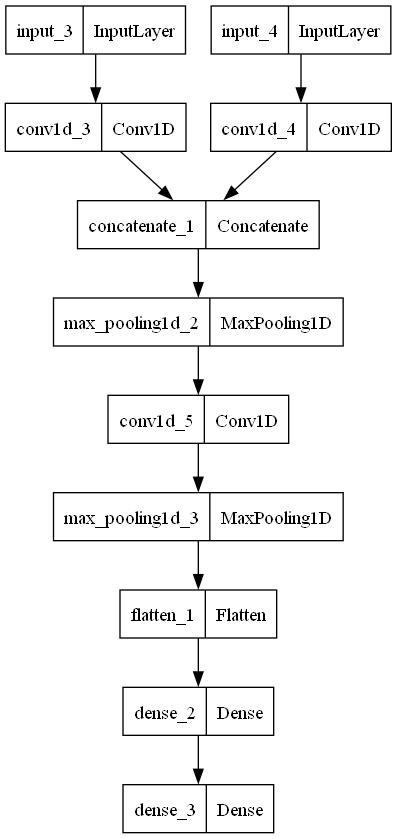

In [34]:
# plot the model
keras.utils.plot_model(multi_model, to_file='files/multi_feature_model.png', show_shapes=False)

In [46]:
history = multi_model.fit(
    [X_mfcc_np_padded, X_chroma_stft_np_padded], 
    y_train_cat,
    epochs=180,
    validation_data=([X_mfcc_test_np_padded, X_chroma_test_stft_np_padded], y_test_cat)
)

Epoch 1/180
31/31 [==============================] - 1s 24ms/step - loss: 0.0693 - accuracy: 0.9448 - val_loss: 2.1974 - val_accuracy: 0.7878
Epoch 2/180
31/31 [==============================] - 1s 25ms/step - loss: 0.0676 - accuracy: 0.9387 - val_loss: 2.2128 - val_accuracy: 0.7918
Epoch 3/180
31/31 [==============================] - 1s 20ms/step - loss: 0.0660 - accuracy: 0.9438 - val_loss: 2.3211 - val_accuracy: 0.7959
Epoch 4/180
31/31 [==============================] - 1s 20ms/step - loss: 0.0660 - accuracy: 0.9459 - val_loss: 2.3608 - val_accuracy: 0.7878
Epoch 5/180
31/31 [==============================] - 1s 20ms/step - loss: 0.0725 - accuracy: 0.9418 - val_loss: 2.1120 - val_accuracy: 0.7755
Epoch 6/180
31/31 [==============================] - 1s 18ms/step - loss: 0.0674 - accuracy: 0.9448 - val_loss: 2.1805 - val_accuracy: 0.7837
Epoch 7/180
31/31 [==============================] - 1s 17ms/step - loss: 0.0667 - accuracy: 0.9428 - val_loss: 2.2526 - val_accuracy: 0.7755
Epoch 

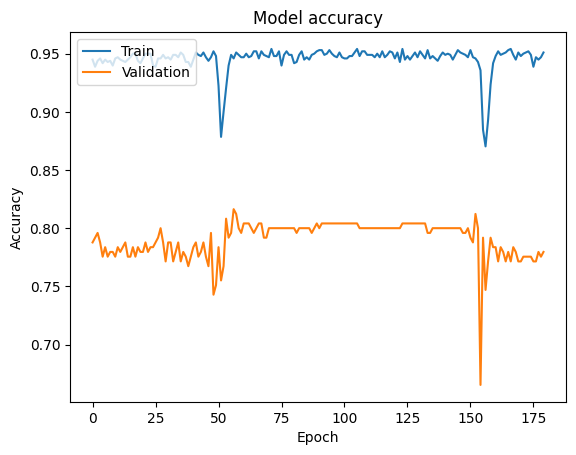

In [47]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


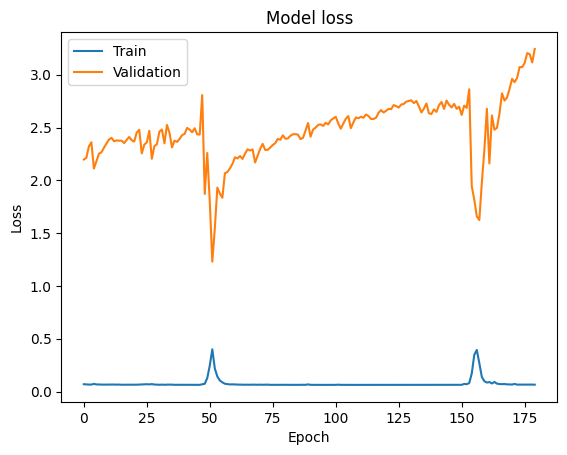

In [48]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [49]:
# save the model
multi_model.save('./files/multi_feature_model.keras')

In [50]:
# Evaluate model
loss, accuracy = multi_model.evaluate([
        X_mfcc_test_np_padded, 
        X_chroma_test_stft_np_padded
    ],
    y_test_cat
)
print("Test Loss:", loss, "Test Accuracy:", accuracy)

1/8 [==>...........................] - ETA: 0s - loss: 2.3115 - accuracy: 0.8125

8/8 [==============================] - 0s 7ms/step - loss: 3.2448 - accuracy: 0.7796
Test Loss: 3.2448019981384277 Test Accuracy: 0.7795918583869934


In [51]:
# Make predictions on new data
multi_predictions = multi_model.predict([
    X_mfcc_test_np_padded, 
    X_chroma_test_stft_np_padded
])

# The predictions will be probabilities for each class
# You can convert these probabilities to class labels
multi_predicted_labels = np.argmax(multi_predictions, axis=1)

# Example of using the predicted labels
print(multi_predicted_labels)

8/8 [==============================] - 0s 6ms/step
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 1 2 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2]


In [52]:
lang_dict

{'canada': 0, 'uk': 1, 'usa': 2}

In [53]:
kyes = list(lang_dict.keys())
values = list(lang_dict.values())

# create index to label with the language_dict values and keys
class_index_to_label = {values[i]: kyes[i] for i in range(len(kyes))}
class_index_to_label

{0: 'canada', 1: 'uk', 2: 'usa'}

In [54]:
# Convert numeric predictions to label names
predicted_labels_names = [class_index_to_label[idx] for idx in np.argmax(multi_predictions, axis=1)]

predicted_labels_names


['usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'canada',
 'usa',
 'usa',
 'usa',
 'canada',
 'uk',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'canada',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'canada',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 '

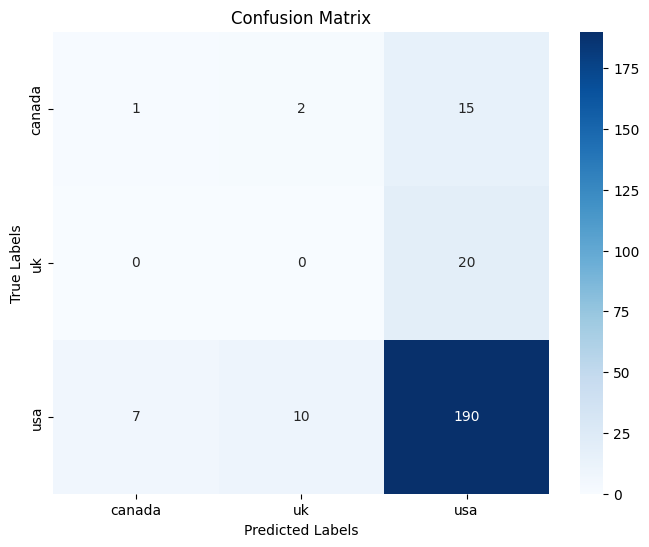

In [55]:
# Convert predicted class indices to one-hot encoded format
label_binarizer = LabelBinarizer()
predicted_labels_one_hot = label_binarizer.fit_transform(multi_predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(y_test_cat.argmax(axis=1), predicted_labels_one_hot.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    cmap='Blues', 
    fmt='g', 
    xticklabels=class_index_to_label.values(), 
    yticklabels=class_index_to_label.values()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('./files/multi_feature_confusion_matrix.png')
plt.show()


# for single feature model - use below cells

In [57]:
# X_train_acoustic is a list of dictionaries with 'mfcc' as one of the features
max_length = 2000  # Define the maximum length you want to pad/truncate to
X_train_acoustic_processed = []
for sample in X_acoustic_list:
    mfcc_array = np.array(sample['mfcc'])
    current_length = mfcc_array.shape[1]
    # Pad or truncate the array to max_length
    if current_length < max_length:
        padded_mfcc_array = np.pad(mfcc_array, ((0, 0), (0, max_length - current_length)), mode='constant')
    else:
        padded_mfcc_array = mfcc_array[:, :max_length]
    X_train_acoustic_processed.append(padded_mfcc_array)

# Convert the list of processed features into a numpy array
X_train_np = np.array(X_train_acoustic_processed)


In [58]:
# Assuming X_train_acoustic is a list of dictionaries with 'mfcc' as one of the features
max_length = 2000  # Define the maximum length you want to pad/truncate to
X_test_acoustic_processed = []
for sample in X_acoustic_test_list:
    mfcc_array = np.array(sample['mfcc'])
    current_length = mfcc_array.shape[1]
    # Pad or truncate the array to max_length
    if current_length < max_length:
        padded_mfcc_array = np.pad(mfcc_array, ((0, 0), (0, max_length - current_length)), mode='constant')
    else:
        padded_mfcc_array = mfcc_array[:, :max_length]
    X_test_acoustic_processed.append(padded_mfcc_array)

# Convert the list of processed features into a numpy array
X_test_np = np.array(X_test_acoustic_processed)


In [59]:
single_model = create_feature_model(X_train_np)

In [60]:
# model summary
single_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40, 2000)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 38, 16)            96016     
                                                                 
 concatenate_2 (Concatenate  (None, 38, 16)            0         
 )                                                               
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 19, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 17, 8)             392       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 8, 8)              0   

In [61]:
os.makedirs("files", exist_ok=True)

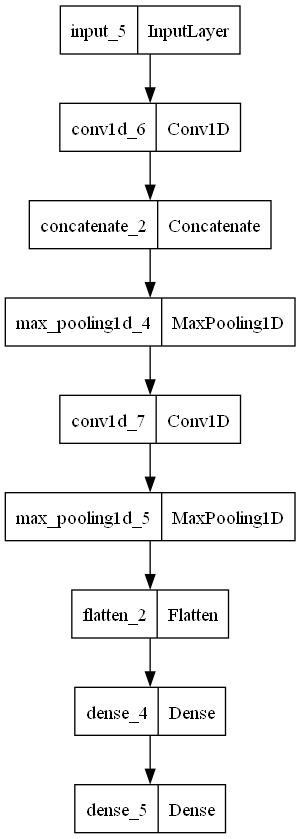

In [62]:
# plot the model
keras.utils.plot_model(single_model, to_file='files/feature_model.png', show_shapes=False)

In [63]:
# X_train_np

In [70]:
# train the model
single_history = single_model.fit(
    X_train_np, 
    y_train_cat, 
    epochs=100,
    validation_data=(X_test_np, y_test_cat)
)

Epoch 1/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0695 - accuracy: 0.9459 - val_loss: 2.6207 - val_accuracy: 0.7755
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0694 - accuracy: 0.9489 - val_loss: 2.5648 - val_accuracy: 0.7714
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0702 - accuracy: 0.9459 - val_loss: 2.5558 - val_accuracy: 0.7755
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0713 - accuracy: 0.9469 - val_loss: 2.4854 - val_accuracy: 0.7796
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0714 - accuracy: 0.9428 - val_loss: 2.4523 - val_accuracy: 0.7796
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0697 - accuracy: 0.9459 - val_loss: 2.5187 - val_accuracy: 0.7755
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0728 - accuracy: 0.9469 - val_loss: 2.3602 - val_accuracy: 0.7673
Epoch 

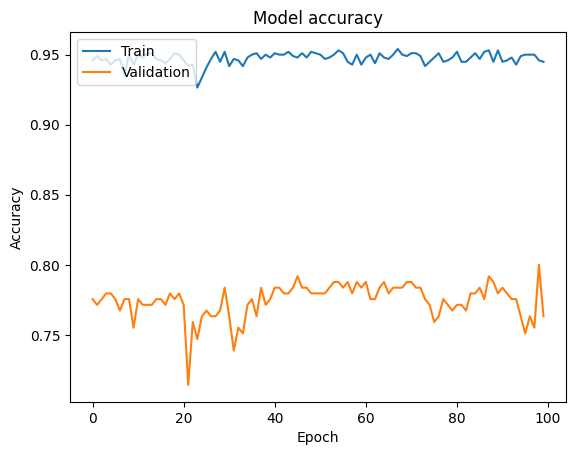

In [71]:
# Plot training & validation accuracy values
plt.plot(single_history.history['accuracy'])
plt.plot(single_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


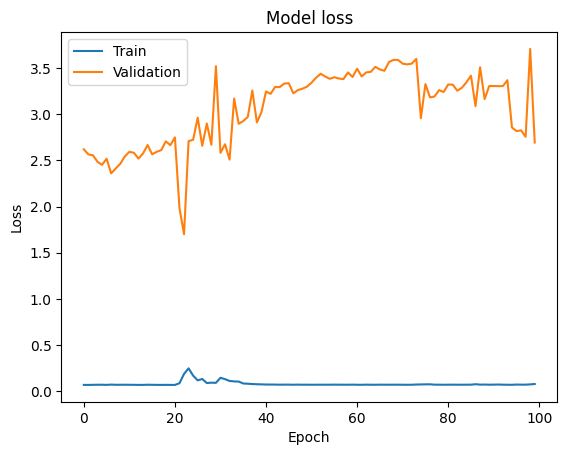

In [72]:
# Plot training & validation loss values
plt.plot(single_history.history['loss'])
plt.plot(single_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
# save the model
single_model.save('./files/feature_model.keras')

In [73]:
# Evaluate model
loss, accuracy = single_model.evaluate(X_test_np, y_test_cat)
print("Test Loss:", loss, "Test Accuracy:", accuracy)

8/8 [==============================] - 0s 7ms/step - loss: 2.6934 - accuracy: 0.7633
Test Loss: 2.69344425201416 Test Accuracy: 0.7632653117179871


In [74]:
# # Make predictions on new data
predictions = single_model.predict(X_test_np)

# The predictions will be probabilities for each class
# You can convert these probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Example of using the predicted labels
print(predicted_labels)


8/8 [==============================] - 0s 5ms/step
[2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 2 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 1 2 2 2 1 2 0 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 0 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2
 1 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 0 2]


In [75]:
# Convert numeric predictions to label names
predicted_labels_names = [class_index_to_label[idx] for idx in np.argmax(multi_predictions, axis=1)]

predicted_labels_names


['usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'canada',
 'usa',
 'usa',
 'usa',
 'canada',
 'uk',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'canada',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'canada',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 '

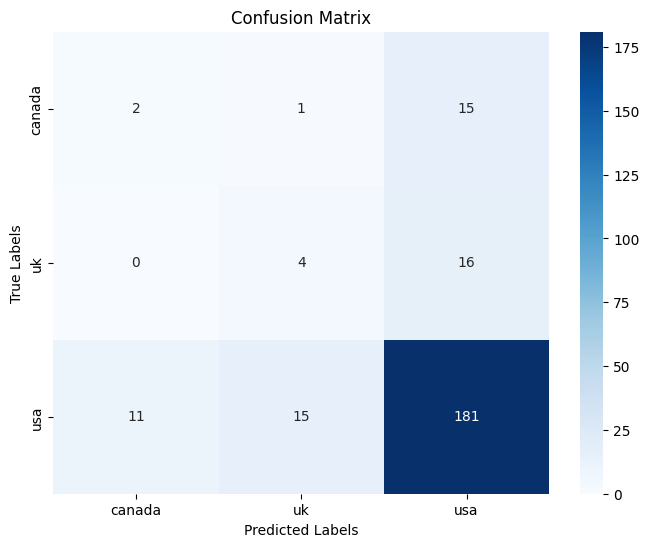

In [76]:
# Convert predicted class indices to one-hot encoded format
label_binarizer = LabelBinarizer()
labels_one_hot = label_binarizer.fit_transform(predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(y_test_cat.argmax(axis=1), labels_one_hot.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    cmap='Blues', 
    fmt='g', 
    xticklabels=class_index_to_label.values(), 
    yticklabels=class_index_to_label.values()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('./files/feature_confusion_matrix.png')
plt.show()


# For Hybrid CNN-LSTM Model

# Choose the approach (concatenation or separate channels)


In [77]:
use_separate_channels = True

# Create CNN-LSTM architecture
hybrid_model = create_hybrid_model(
    X_mfcc_np=X_mfcc_np_padded,
    X_chroma_stft_np=X_chroma_stft_np_padded,
    # X_spectral_centroid_np=X_spectral_centroid_np,
    use_separate_channels=use_separate_channels
)

In [78]:
# model summary
hybrid_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 40, 2000)]           0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 40, 2000)]           0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 40, 16)               96016     ['input_6[0][0]']             
                                                                                                  
 conv1d_9 (Conv1D)           (None, 40, 8)                48008     ['input_7[0][0]']             
                                                                                            

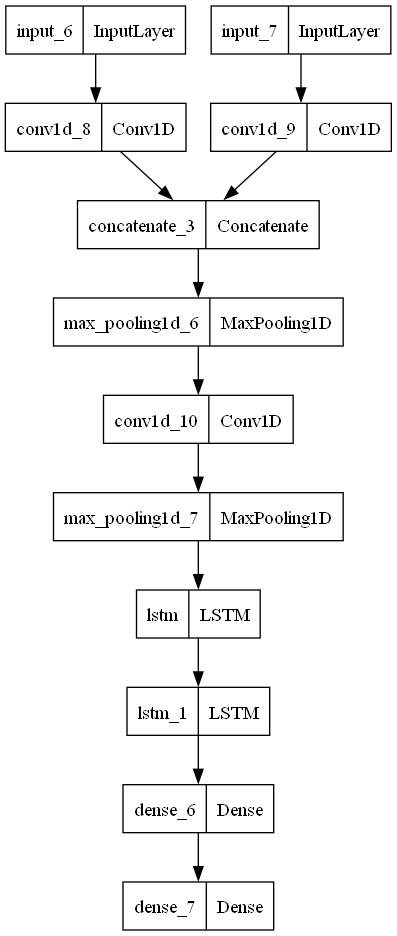

In [79]:
# plot model
keras.utils.plot_model(hybrid_model, to_file='files/hybrid_feature_model.png', show_shapes=False)

In [84]:
history = hybrid_model.fit(
    [X_mfcc_np_padded, X_chroma_stft_np_padded],
    y_train_cat,
    epochs=50, # EPOCHS
    validation_data=([X_mfcc_test_np_padded, X_chroma_test_stft_np_padded], y_test_cat)
)

Epoch 1/50
31/31 [==============================] - 1s 36ms/step - loss: 0.2306 - accuracy: 0.8999 - val_loss: 1.0400 - val_accuracy: 0.8082
Epoch 2/50
31/31 [==============================] - 1s 33ms/step - loss: 0.2686 - accuracy: 0.8917 - val_loss: 0.7929 - val_accuracy: 0.8163
Epoch 3/50
31/31 [==============================] - 1s 30ms/step - loss: 0.2058 - accuracy: 0.9111 - val_loss: 1.0377 - val_accuracy: 0.7755
Epoch 4/50
31/31 [==============================] - 1s 29ms/step - loss: 0.1727 - accuracy: 0.9305 - val_loss: 1.0286 - val_accuracy: 0.7306
Epoch 5/50
31/31 [==============================] - 1s 30ms/step - loss: 0.1428 - accuracy: 0.9336 - val_loss: 1.2698 - val_accuracy: 0.6653
Epoch 6/50
31/31 [==============================] - 1s 30ms/step - loss: 0.1332 - accuracy: 0.9346 - val_loss: 1.2488 - val_accuracy: 0.7714
Epoch 7/50
31/31 [==============================] - 1s 29ms/step - loss: 0.1152 - accuracy: 0.9428 - val_loss: 1.4252 - val_accuracy: 0.7510
Epoch 8/50
31

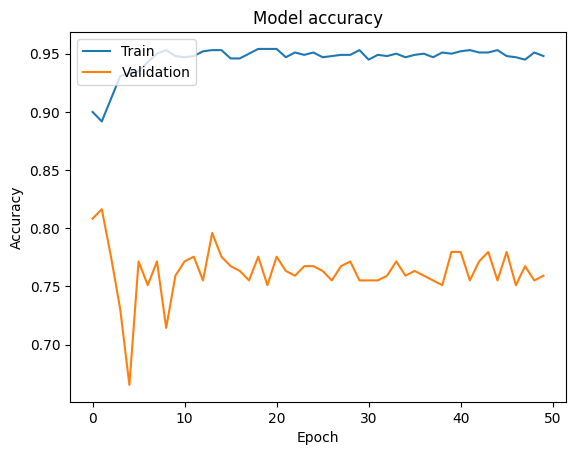

In [85]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

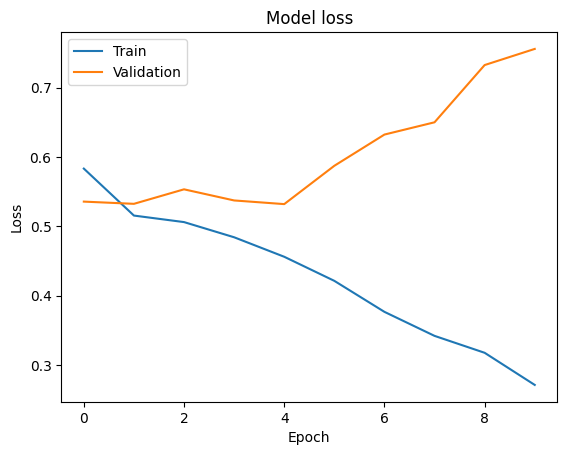

In [61]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [62]:
# save the model
hybrid_model.save('./files/hybrid_feature_model.keras')

In [63]:
# Evaluate model
loss, accuracy = hybrid_model.evaluate([
        X_mfcc_test_np_padded, 
        X_chroma_test_stft_np_padded
    ],
    y_test_cat
)
print("Test Loss:", loss, "Test Accuracy:", accuracy)

8/8 [==============================] - 0s 10ms/step - loss: 0.7559 - accuracy: 0.7633
Test Loss: 0.755898118019104 Test Accuracy: 0.7632653117179871


In [64]:
# Make predictions on new data
hybrid_predictions = hybrid_model.predict([
    X_mfcc_test_np_padded, 
    X_chroma_test_stft_np_padded
])

# The predictions will be probabilities for each class
# You can convert these probabilities to class labels
hybrid_predicted_labels = np.argmax(hybrid_predictions, axis=1)

# Example of using the predicted labels
print(multi_predicted_labels)

8/8 [==============================] - 2s 12ms/step
[2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 0 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 1 2]


In [76]:
# Convert numeric predictions to label names
predicted_labels_names = [class_index_to_label[idx] for idx in np.argmax(hybrid_predictions, axis=1)]

predicted_labels_names


['usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'canada',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'uk',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa',
 'usa',
 'usa',
 'uk',
 'usa'

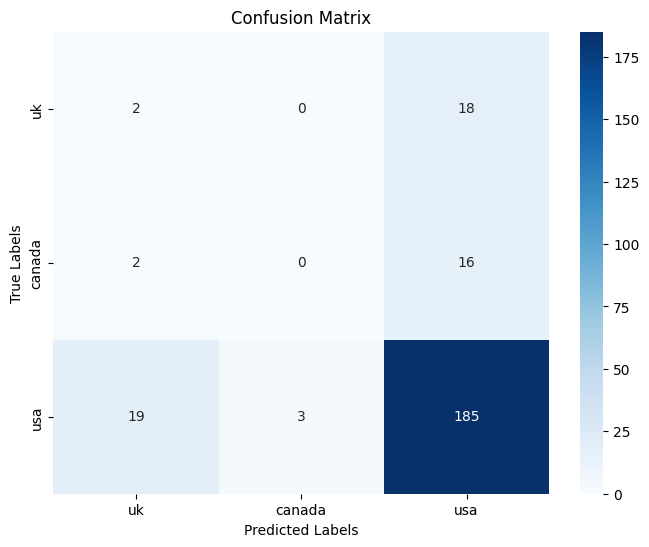

In [77]:
# Convert predicted class indices to one-hot encoded format
label_binarizer = LabelBinarizer()
predicted_labels_one_hot = label_binarizer.fit_transform(hybrid_predicted_labels)

# Calculate confusion matrix
cm = confusion_matrix(y_test_cat.argmax(axis=1), predicted_labels_one_hot.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    cmap='Blues', 
    fmt='g', 
    xticklabels=class_index_to_label.values(), 
    yticklabels=class_index_to_label.values()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('./files/hybrid_feature_confusion_matrix.png')
plt.show()
